In this project, we will use Convolutional Neural Network to build train and test a traffic sign classification model. We will build this model using tensorflow and keras. It is a multiclass classification problem. This model can be used to make smarter cars.

We will start by connecting to Kaggle using Kaggle API which can be downloaded from your Kaggle account's settings and uploading it here(upload box).

In [1]:
# Run this cell and select the kaggle.json file downloaded from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"parthkalkar","key":"88070c12ac121cb5fcb1c4bdfe56476f"}'}

Installing kaggle api using pip

In [2]:
# Next, install the Kaggle API client.
!pip install -q kaggle

Setting up Kaggle using Kaggle API.

In [3]:
# The Kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

To store the data we will create a new directory and make it as current working directory.

In [4]:
# Creating directory and changing the current working directory
!mkdir traffic_sign_dataset
%cd traffic_sign_dataset

/content/traffic_sign_dataset


Searching Kaggle for the required dataset using search option(-s) with title 'dogbreedidfromcomp'. We can also use different search options like searching competitions, notebooks, kernels, datasets, etc.

In [5]:
# Searching for dataset
!kaggle datasets list -s gtsrb-german-traffic-sign

ref                                                                title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meowmeowmeowmeowmeow/gtsrb-german-traffic-sign                     GTSRB - German Traffic Sign Recognition Benchmark  612MB  2018-11-25 18:12:34          67243        882  0.8235294        
valentynsichkar/traffic-signs-preprocessed                         Traffic Signs Preprocessed                           4GB  2019-08-31 18:22:11           8883        234  1.0              
eunjurho/german-traffic-sign-recognition-benchmark-cropped         german_traffic_sign_recognition_benchmark_cropped  206MB  2019-11-10 15:22:13            320          8  0.75             
bhavinmoriya/german-traffic-sign-recognition-bench

After searching the data next step would be downloading the data into collab notebook using references found in search option.

In [6]:
# Downloading dataset and coming out of directory
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign  
%cd ..

100% 610M/612M [00:03<00:00, 217MB/s]
100% 612M/612M [00:03<00:00, 179MB/s]
/content


We will unzip the data which is downloaded and remove the irrelevant files.

In [7]:
# Unzipping downloaded file and removing unusable file
!unzip traffic_sign_dataset/gtsrb-german-traffic-sign.zip -d traffic_sign_dataset
!rm traffic_sign_dataset/gtsrb-german-traffic-sign.zip
!rm -rf traffic_sign_dataset/Meta
!rm -rf traffic_sign_dataset/meta
!rm -rf traffic_sign_dataset/test
!rm -rf traffic_sign_dataset/train
!rm traffic_sign_dataset/Meta.csv

Streaming output truncated to the last 5000 lines.
  inflating: traffic_sign_dataset/train/5/00005_00053_00010.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00011.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00012.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00013.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00014.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00015.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00016.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00017.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00018.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00019.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00020.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00021.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00022.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00023.png  
  inflating: traffic_sign

Importing required libraries.

In [8]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image
from sklearn.model_selection import  train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D

Visualizing some images of traffic sign from the test dataset. we can see here that the dimension of images are uneven.

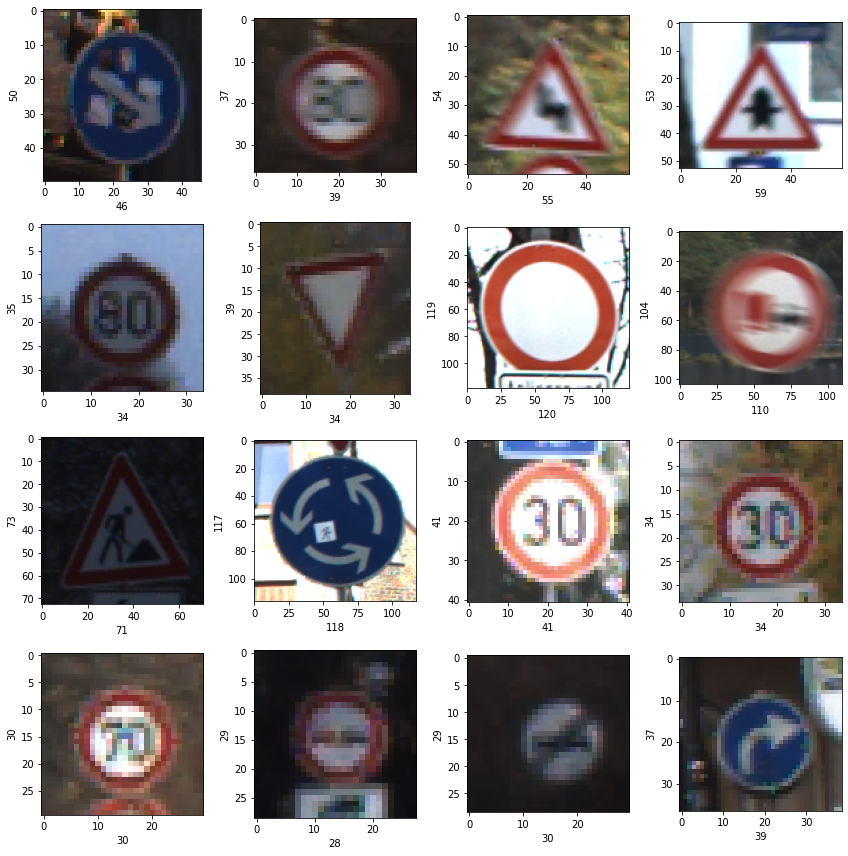

In [9]:
# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))
path = "traffic_sign_dataset/Test"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

For further processing we will require the images of same dimension. So, we will start storing the dimension of all the images from training dataset from all 43 classes.  

In [10]:
# As size of images are different we have to make them equal so we will take mean of dimanesions
dim1 = []
dim2 = []

for i in range(0,43):
    labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = imread(labels + '/' + x)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])

Now we will find out the mean value of both the dimensions and analyse them. Here, we can see that (50,50) is the average shape for all the images.

In [11]:
#Printing mean dimension of images
print("Dimension 1 Mean : ",np.mean(dim1), " Dimension 2 Mean : ",np.mean(dim2))

Dimension 1 Mean :  50.328929582493814  Dimension 2 Mean :  50.83587951745773


Now we will reshape the images into (50,50) and also store their label ids.

In [12]:
# Now we will reshape the images to (50,50)
images = []
label_id = []

for i in range(43):
    labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = Image.open(labels + '/' + x)
        img = img.resize((50,50))
        img = np.array(img)
        images.append(img)
        label_id.append(i)

Now we will convert all the images into numpy array and normalize them.

In [13]:
#Converting images into numpy array
images = np.array(images)
#The pixel value of each image ranges between 0 and 255
#Dividing each image by 255 will scale the values between 0 and 1. This is also known as normalization.
images = images/255 

Storing the label ids into numpy array and printing the shape. Here we can observe that their are 39209 label ids.

In [14]:
label_id = np.array(label_id)
label_id.shape

(39209,)

Checking the shape of the images. Here we can see that their are 39209 images with a shape of (50,50,3.)

In [15]:
images.shape

(39209, 50, 50, 3)

Now we will observe images per class for checking whether the data is balanced or not. From the result we can say that data is balanced.

In [16]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_id).value_counts()
label_counts.head()

2     2250
1     2220
13    2160
12    2100
38    2070
dtype: int64

The next step would be to split the data into training and validation with 80% of training data and 20% of validation data.

In [17]:
#Splitting the data
x_train, x_val, y_train, y_val = train_test_split(images, label_id , test_size = 0.2, random_state = 42)

Converting the classes column into categorical using to_categorical() function.

In [18]:
#keras has a built-in function for one-hot encoding.
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

Defining the model architecture. In this we will define all the layers with their input shape kernel size, activation, etc.

In [19]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = x_train.shape[1:], activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation = 'softmax'))

Compiling the model using metrics, optimizer and loss as required and printing out the summary of the model.

In [20]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 64)        0

Now we will fit the model and observe how our is getting trained on each epoch.

In [21]:
model.fit(x_train, y_train, epochs = 10, batch_size = 128, validation_data = (x_val, y_val), verbose = 2)

Epoch 1/10
246/246 - 16s - loss: 2.4080 - accuracy: 0.3378 - val_loss: 1.2054 - val_accuracy: 0.6635 - 16s/epoch - 65ms/step
Epoch 2/10
246/246 - 4s - loss: 1.1413 - accuracy: 0.6407 - val_loss: 0.4947 - val_accuracy: 0.9000 - 4s/epoch - 17ms/step
Epoch 3/10
246/246 - 4s - loss: 0.7241 - accuracy: 0.7681 - val_loss: 0.2773 - val_accuracy: 0.9444 - 4s/epoch - 17ms/step
Epoch 4/10
246/246 - 4s - loss: 0.5552 - accuracy: 0.8215 - val_loss: 0.1753 - val_accuracy: 0.9658 - 4s/epoch - 17ms/step
Epoch 5/10
246/246 - 4s - loss: 0.4681 - accuracy: 0.8506 - val_loss: 0.1310 - val_accuracy: 0.9745 - 4s/epoch - 18ms/step
Epoch 6/10
246/246 - 4s - loss: 0.3980 - accuracy: 0.8684 - val_loss: 0.1197 - val_accuracy: 0.9806 - 4s/epoch - 17ms/step
Epoch 7/10
246/246 - 4s - loss: 0.3680 - accuracy: 0.8823 - val_loss: 0.1021 - val_accuracy: 0.9823 - 4s/epoch - 17ms/step
Epoch 8/10
246/246 - 4s - loss: 0.3305 - accuracy: 0.8943 - val_loss: 0.0798 - val_accuracy: 0.9839 - 4s/epoch - 18ms/step
Epoch 9/10
246

Next we will visualize the accuracy and loss per epoch. For this we will store the model history in the pandas dataframe and plot them.

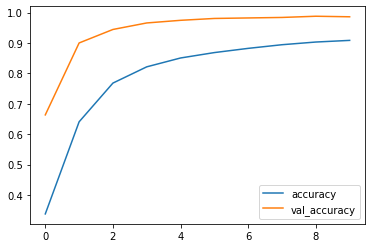

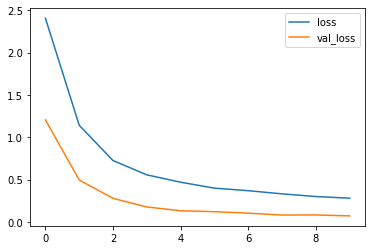

In [22]:
evaluation = pd.DataFrame(model.history.history)
evaluation[['accuracy', 'val_accuracy']].plot()
evaluation[['loss', 'val_loss']].plot()

Creating the variable which has path of test dataset. As we downloded the dataset we found out that their is a GT-final_test.csv file in the test images folder which cannot be processed. So, we will remove that file.

In [23]:
test_path = 'traffic_sign_dataset/Test'
!rm traffic_sign_dataset/Test/GT-final_test.csv

Next step would we creating a function to resize the test images converting them into a numpy array and normalize them.

In [24]:
#defining a function that will scale images
from PIL import Image

def scaling(test_images, test_path):
    images = []

    image_path = test_images
    
    for x in image_path:
        img = Image.open(test_path + '/' + x)
        img = img.resize((50,50))
        img = np.array(img)
        images.append(img)

    #Converting images into numpy array
    images = np.array(images)
    #The pixel value of each image ranges between 0 and 255
    #Dividing each image by 255 will scale the values between 0 and 1. This is also known as normalization.
    images = images/255

    return images

Calling the above created function on test images.

In [25]:
test_images = scaling(sorted(os.listdir(test_path)),test_path)

Next we will read label ids from Test.csv and store the values of the class id in y_test variable.

In [26]:
test = pd.read_csv('traffic_sign_dataset/Test.csv')
y_test = test['ClassId'].values
y_test

array([16,  1, 38, ...,  6,  7, 10])

Now we will use the model to make predictions on our test images and save them in y_pred.

In [28]:
predict_x=model.predict(test_images) 
classes_x=np.argmax(predict_x,axis=1)
classes_x
# y_pred = model.predict_classes(test_images);
# y_pred

395/395 [==============================] - 1s 3ms/step


array([16,  1, 38, ...,  5,  7, 10])

Storing the labels according to the image classes.

In [29]:
# Storing all lables
all_lables = ['Speed limit (20km/h)','Speed limit (30km/h)','Speed limit (50km/h)','Speed limit (60km/h)',
              'Speed limit (70km/h)','Speed limit (80km/h)','End of speed limit (80km/h)','Speed limit (100km/h)',
              'Speed limit (120km/h)','No passing','No passing for vechiles over 3.5 metric tons',
              'Right-of-way at the next intersection','Priority road','Yield','Stop','No vechiles',
              'Vechiles over 3.5 metric tons prohibited','No entry','General caution','Dangerous curve to the left',
              'Dangerous curve to the right','Double curve','Bumpy road','Slippery road','Road narrows on the right',
              'Road work','Traffic signals','Pedestrians','Children crossing','Bicycles crossing','Beware of ice/snow',
              'Wild animals crossing','End of all speed and passing limits','Turn right ahead','Turn left ahead',
              'Ahead only','Go straight or right','Go straight or left','Keep right','Keep left','Roundabout mandatory',
              'End of no passing','End of no passing by vechiles over 3.5 metric']

Let's visualize test image

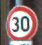

In [30]:
# Visualize test image
img = Image.open(test_path + '/00001.png')
img

Finding out original label for the image above.

In [31]:
# Original label
print("Original label : ",all_lables[y_test[1]])

Original label :  Speed limit (30km/h)


Finding out the predicted label for the image above.

In [32]:
# Predicted label
print("Predicted label : ",all_lables[classes_x[1]])

Predicted label :  Speed limit (30km/h)


## Conclusion:

We started with downloading the dataset, preprocessing it, created the model and found out the predictions using the model. During preprocessing we found that this dataset has 43 classes. Model reached an accuracy of 95%+ in just 50 epochs, we can further optimize the model using hyper parameter tuning and reach a higher accuracy. 

# Scope:

This model can be used in self driving cars which will enable them to automatically recognize traffic signs similarly the driver alert system inside cars will help and protect drivers by understanding the traffic signs around them.